In [233]:
import torch, numpy, tqdm, matplotlib, graphviz, tiktoken
print("torch:", torch.__version__)
print("numpy:", numpy.__version__)

torch: 2.8.0
numpy: 2.3.1


In [234]:
!pip install torch torchvision torchaudio
!pip install matplotlib
!pip install graphviz
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [235]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [737]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = float(data)
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
        
    def __add__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
            
        out._backward = _backward
        return out
        
    def __mul__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
            
        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        return self * other**-1

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def __rsub__(self, other):     # float - Value
        other = other if isinstance(other, Value) else Value(other)
        return other - self

    def __radd__(self, other):     # float + Value
        return self + other

    def __rtruediv__(self, other): # float / Value
        other = other if isinstance(other, Value) else Value(other)
        return other * (self ** -1)
        
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1-t**2) * out.grad
        out._backward = _backward
        
        return out

    def relu(self):
        y = self.data if self.data > 0 else 0.0
        out = Value(y, (self,), 'relu')
        
        def _backward():
            self.grad += (1.0 if out.data > 0 else 0.0) * out.grad
        out._backward = _backward
        
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = Value(self.data ** other, (self,), f'**({other})')

        def _backward():
            self.grad += other * self.data ** (other - 1) * out.grad
        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
          if v not in visited:
            visited.add(v)
            for child in v._prev:
              build_topo(child)
            topo.append(v)
        build_topo(self)
        topo
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [237]:
#inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#biases
b = Value(6.881373587019543, label='b')
#Z values
x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1 + x2w2'
n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label='o'

In [238]:
o.backward()

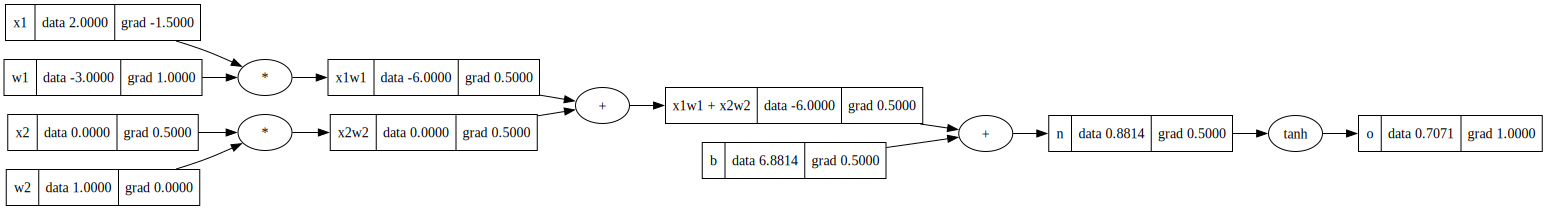

In [239]:
draw_dot(o)

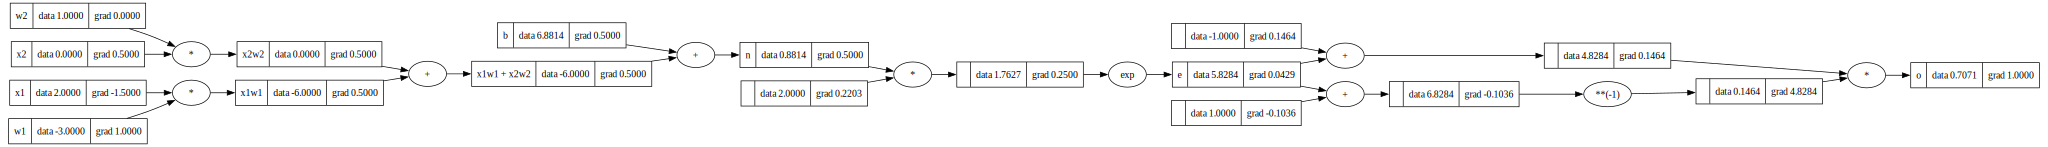

In [240]:
#inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#biases
b = Value(6.881373587019543, label='b')
#Z values
x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1 + x2w2'
n = x1w1x2w2 + b; n.label='n'
e = (2*n).exp(); e.label='e'
o = (e-1)/(e+1); o.label='o'
o.backward()
draw_dot(o)

In [241]:
import torch

In [740]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.relu(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.881373405456543
---
x2 1.0
w2 0.0
x1 -3.0
w1 2.0


In [774]:
class Neuron:

    def __init__(self, nin): #nin is number of neurons inupts
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x): # w dot product x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b) #finding Z-value
        out = act.relu() #activation funciton on Z
        return out

    def parameters(self):
        return self.w + [self.b] #theta for a neuron (list of all weights and biases for a neuron)
        
class Layer:

    def __init__(self, nin, nout): #nout is number of outputs in the layer = number of neurons in layer
        self.neurons = [Neuron(nin) for _ in range(nout)] #each neuron in layer connected to all neurons in prev layer
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons] #evaluate each neuron independently
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()] #theta of a list
        
class MLP:

    def __init__(self, nin, nouts): #nouts is a list of the number fo neurons in each layer
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range (len(nouts))] #each layer in the MLP

    def __call__(self, x):
        for layer in self.layers: #propogate through all the layers, calculating the nin for 
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()] #theta of MLP
        

In [775]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.0)

In [776]:
n.parameters() #theta

[Value(data=0.9430414661093447),
 Value(data=-0.8816688092402709),
 Value(data=-0.9530895552618277),
 Value(data=0.8414881163535606),
 Value(data=0.4269687411722969),
 Value(data=0.16663924913022354),
 Value(data=-0.3298070865937084),
 Value(data=0.3693365910432802),
 Value(data=-0.7457292114983312),
 Value(data=-0.48652095947227036),
 Value(data=0.7665781554460904),
 Value(data=0.42508127553330044),
 Value(data=0.5658194585414646),
 Value(data=0.4526232612101546),
 Value(data=-0.5323657731518268),
 Value(data=-0.09638608877017107),
 Value(data=-0.36313249349534193),
 Value(data=-0.25681346790999515),
 Value(data=-0.9708214306643366),
 Value(data=-0.5796986605588728),
 Value(data=0.7034574092165577),
 Value(data=0.3129142042186741),
 Value(data=0.527719321228753),
 Value(data=0.08912002328457325),
 Value(data=0.6638384965759816),
 Value(data=0.7474848230846549),
 Value(data=-0.8114335170235314),
 Value(data=-0.0756030195941706),
 Value(data=0.3717882553823939),
 Value(data=-0.106053088

In [777]:
#training MLP on training set 'xs'

xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [5.0, -3.0, -0.85, 1.0] #desired targets (used to find loss)

In [778]:
#alpha (learning rate)
lr = 0.1

In [779]:
#gradient descent automation

for k in range (9999):
    #forward pass
    ypred = [n(x) for x in xs] #what our current w's and b's give
    loss = ((2*len(ys))**-1) * sum((yout - ygt)**2 for yout, ygt in zip(ys, ypred))

    #backward pass
    #Calculate the gradient of everything in the loss function (the loss function is the MLP put through one more operation (loss function)
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    #iterate theta by subtracting each neurons grad from it's value
    for p in n.parameters():
        p.data += -lr * p.grad

print(k, loss.data)

9998 4.4653125


In [780]:
print (ypred)

[Value(data=0.0), Value(data=0.0), Value(data=0.0), Value(data=0.0)]


In [781]:
for p in n.parameters():
    print(p.grad)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
